# Task 3 Activation Map Reconstruction


## PLAN

### 1.1 Dataset Instruction

Download the dataset from the [Dataset of Simulated Intracardiac Transmembrane Voltage Recordings and ECG Signals](https://library.ucsd.edu/dc/object/bb29449106) by running following command: 

```bash
source download_intracardiac_dataset.sh
```

### 1.2 Task Description

*Understand the time when each part of the heart is activated.*

The objective is to build a model that can predict the activation times at the 75 myocardial points based on the ECG data from the 12 leads.

### 1.3 Load Modules and Preprocessing Functions

In [407]:
# Analysis
import numpy as np
import pandas as pd

import glob, re, os
from typing import List

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# # Evaluate
# from sklearn.metrics import mean_absolute_error
# from sklearn.metrics import mean_squared_error
# from sklearn.metrics import r2_score

# Data processing
from torch.utils.data import DataLoader, TensorDataset
from sklearn.utils import shuffle

# Save model
import pickle

# Ignore warning
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_rows", 100)
plt.style.use('ggplot')

In [408]:
# Run the cardiac_ml_tools.py script
%run ./cardiac_challenge/notebooks/cardiac_ml_tools.py

In [409]:
# Load the dataset
data_dirs = []
regex = r'data_hearts_dd_0p2*'
DIR = './cardiac_challenge/intracardiac_dataset/' # path to the intracardiac_dataset

for x in os.listdir(DIR):
    if re.match(regex, x):
        data_dirs.append(DIR + x)
file_pairs = read_data_dirs(data_dirs)
print('Number of file pairs: {}'.format(len(file_pairs)))
# example of file pair
print("Example of file pair:")
print("{}\n{}".format(file_pairs[0][0], file_pairs[0][1]))


Number of file pairs: 16117
Example of file pair:
./cardiac_challenge/intracardiac_dataset/data_hearts_dd_0p2_geo_inn_act_3_bcl/pECGData_hearts_dd_0p2_geo_inn_act_3_bcl_bcl.1000.innerindex.0.volunteer.v13.npy
./cardiac_challenge/intracardiac_dataset/data_hearts_dd_0p2_geo_inn_act_3_bcl/VmData_hearts_dd_0p2_geo_inn_act_3_bcl_bcl.1000.innerindex.0.volunteer.v13.npy


### 1.4 Dataset details


The dataset [Dataset of Simulated Intracardiac Transmembrane Voltage Recordings and ECG Signals](https://library.ucsd.edu/dc/object/bb29449106) 
consists of pairs of computationally simulated intracardiac transmembrane voltage recordings and ECG signals.
In total, 16140 organ-level simulations were conducted to create this dataset.
Simulations were performed using Lassen supercomputer at Lawrence Livermore National Lab (LLNL), concurrently utilizing 4 GPUs and 40 CPU cores.
Each simulation produced pairs of 500ms-by-10 raw electrode signals and 500ms-by-75 transmembrane voltage signals.
For convenience, we collect those signals in matrices and give them the following names:

Tensor | Description | Shape | Notes
--- | --- | --- | ---
$X$ | Row electrode signals | $10 \times 500$ | 10-lead ECG signals from the simulated torso (in [Dataset of Simulated Intracardiac Transmembrane Voltage Recordings and ECG Signals](https://library.ucsd.edu/dc/object/bb29449106))
$V$ | Activation map | $75 \times 500$ | Transmembrane voltage signals from the simulated heart (in [Dataset of Simulated Intracardiac Transmembrane Voltage Recordings and ECG Signals](https://library.ucsd.edu/dc/object/bb29449106))
$E$ | 12-lead ECG signals | $12 \times 500$ | 12-lead ECG signals obtained by `get_standard_leads`($X$)
$A$ | Activation map | $75 \times 1$ | Activation time, defined as $A_i = \text{min}_j(V_{ij})$

**IMPORTANT** : The raw data in the dataset consists of 10-lead ECG signals and 75-lead transmembrane voltage signals. The 12-lead ECG signals are obtained from the 10-lead ECG signals using the function `get_standard_leads` (in the file `cardiac_ml_tools.py`).

The overall generation process is shown in the following image. The ECG signal is recorded using 10 virtual electrodes and the transmembrane voltages are recorded at 75 points within the myocardium. The transmembrane voltages are then used to generate the spatio-temporal activation maps.

![if picture not show, see path "/cardiac_challenge/figures/data_generation.png"](./cardiac_challenge/figures/data_generation.png)

## ANALYZE

### 2.1 Getting the standard 12-lead ECG from the 10-lead ECG

The function `get_standard_leads` (in the file `cardiac_ml_tools.py`) is used to obtain the 12-lead ECG signals from the 10-lead ECG signals. It implements the following transformation, where the (Wilson Lead) is defined as $Vw = 1/3*(RA + LA + LL)$:
$$
\left\{
\begin{array}{lll}
    X_{:,1}  & \to  & RA \\
    X_{:,2}  & \to  & LA \\
    X_{:,3}  & \to  & LL \\
    X_{:,4}  & \to  & RL \\
    X_{:,5}  & \to  & V1 \\
    X_{:,6}  & \to  & V2 \\
    X_{:,7}  & \to  & V3 \\
    X_{:,8}  & \to  & V4 \\
    X_{:,9}  & \to  & V5 \\
    X_{:,10} & \to &  V6 \\
\end{array}
\right.
\text{        and        }
\left\{
\begin{array}{lll}          
\text{Lead } I& : & LA - RA \\
\text{Lead } II& : & LL - RA \\
\text{Lead } III& : & LL - LA \\
\text{Lead } aVR& : &  \frac{3}{2} (RA - Vw) \\
\text{Lead } aVL& : &  \frac{3}{2} (LA - Vw) \\
\text{Lead } aVF& : &  \frac{3}{2} (LL - Vw)\\ 
\text{Lead } V1 & : & V1 - Vw \\
\text{Lead } V2 & : & V2 - Vw \\
\text{Lead } V3 & : & V3 - Vw \\
\text{Lead } V4 & : & V4 - Vw \\
\text{Lead } V5 & : & V5 - Vw \\
\text{Lead } V6 & : & V6 - Vw \\
\end{array}
\right.
$$

In [410]:
# # Example of file pair
# case = 213
# # ECG plot
# row = 3 
# column = 4
# num_timesteps = 500
# plt.figure(figsize=(10, 7))
# titles = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
# reorder = {1:1,2:5,3:9,4:2,5:6,6:10,7:3,8:7,9:11,10:4,11:8,12:12} # reorder the leads to standard 12-lead ECG display

# print('Case {} : {}'.format(case, file_pairs[case][0]))
# pECGData = np.load(file_pairs[case][0])
# pECGData = get_standard_leads(pECGData)

# # create a figure with 12 subplots
# for i in range(pECGData.shape[1]):
#     plt.subplot(row, column, reorder[i + 1])
#     plt.plot(pECGData[0:num_timesteps,i],'r', color='blue', alpha=0.8)
#     plt.title(titles[i])
#     # plt.plot(visible=True, color='blue', linestyle='-')
#     plt.minorticks_on()
#     # plt.plot(visible=True, color='blue', linestyle='-', alpha=0.2)
#     plt.xlabel('msec')
#     plt.ylabel('mV')
# plt.tight_layout()
# plt.show()
# # close
# plt.close()

### 2.2 Getting the activation map from the transmembrane voltages

The funtion `get_activation_map` (in the file `cardiac_ml_tools.py`) is used to obtain the activation map from the transmembrane voltages. It implements the following transformation $A_i = \text{min}_j(V_{ij})$.

In [411]:
# # Example of file pair
# case = 213
# # plt.figure(figsize=(1, 10))
# plt.figure(figsize=(15, 2))

# print('Case {} : {}'.format(case, file_pairs[case][0]))
# VmData = np.load(file_pairs[case][1])

# ActTime = get_activation_time(VmData)

# # plot the Activation Time array
# plt.imshow(ActTime.T, cmap='jet', interpolation='nearest', aspect='auto')
# plt.title('Activation Time')
# plt.colorbar()
# plt.grid(visible=True, which='major', color='#666666', linestyle='-')
# plt.minorticks_on()
# # not yticks
# plt.yticks([])
# plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
# plt.show()


### 3.3 Learning the mapping from the 12-lead ECG to the activation map

In [412]:
# # make a plot with the "pECGData" -> "ActTime"
# case = 213

# print('Case {} : {}'.format(case, file_pairs[case][0]))
# pECGData = np.load(file_pairs[case][0])
# pECGData = get_standard_leads(pECGData)

# print('Case {} : {}'.format(case, file_pairs[case][0]))
# VmData = np.load(file_pairs[case][1])
# ActTime = get_activation_time(VmData)

# # plot in row the tensors pECGData and ActTime with an arrow pointing to the activation time
# row = 1
# column = 3
# plt.figure(figsize=(20, 5))
# plt.subplot(row, column, 1)
# # plot pECGData transposed
# plt.imshow(pECGData.T, cmap='jet', interpolation='nearest', aspect='auto')
# plt.title('pECGData')
# plt.subplot(row, column, 2)
# # print an arrow
# plt.text(0.5, 0.5, '-------->', horizontalalignment='center', verticalalignment='center', fontsize=20)
# plt.axis('off')
# plt.subplot(row, column, 3)
# # plot ActTime
# plt.imshow(ActTime, cmap='jet', interpolation='nearest', aspect='auto')
# # not xticks
# plt.xticks([])
# plt.title('ActTime')
# plt.show()
# plt.close()

**Tricks**

As in many machine learning problems, normalization of the data might be helpful or even necessary. Different normalization schemes might be applied.

## CONSTRUCT

**Model: 1D CNN**

**Approach**

We to flatten each 2D sample (12x500) from the ECG data into a 1D row, transforming each sample from a matrix into a long vector. Then, you want to stack all these vectors from over 16,000 samples into a single large dataset where each row represents one sample, fully flattened, resulting in a dataset with dimensions of (16000, 6000) — since 12 x 500 = 6000.

Here’s the step-by-step plan to achieve this:

1. **Flatten Each Sample**: Each 12x500 matrix will be reshaped into a single row of 6000 elements. This converts the 2D feature set of each sample into a 1D array.

2. **Stack All Samples**: After flattening each sample, you'll stack them vertically to create a new dataset where each row corresponds to one of the original 2D samples, now represented as a long 1D vector.

3. **Create a Uniform Dataset**: The result will be a large dataset where every sample is consistently formatted in a single row, making it easier to handle in terms of data processing and input into machine learning models.

4. **Store or Process This Dataset**: Depending on the final application, this dataset can then be either stored for further use, processed for normalization, or directly used as input for machine learning models, particularly for tasks like clustering, classification, or regression.

This approach effectively transforms a complex 2D dataset into a more manageable 1D format, albeit at the expense of increasing the dimensionality of each data point. This can be useful for certain types of analyses or machine learning models that require a flat vector per sample.

**Combine Dataset Approach**

Given that your full dataset contains over 16,000 samples, here's a graduated approach to determining an initial subset size:

- **Initial Proof of Concept**: Start with a very small amount of data, perhaps around **100 to 500 samples**. This size is usually sufficient to ensure that your data loading, processing, and model training pipelines are functioning correctly without excessive computational overhead.

- **Preliminary Testing**: Once your initial setup is verified to be working correctly, increase the size to about **1,000 to 2,000 samples**. This provides a more statistically significant dataset to start tuning hyperparameters and testing model performance while still being manageable in terms of computational resources and time.

- **Detailed Testing and Validation**: If the model performs well on 1,000 to 2,000 samples, consider using a larger subset, such as **5,000 to 10,000 samples**, to further refine your model and prepare for full-scale training. This step is crucial for understanding how well the model scales with data size and for final adjustments before deploying the model on the entire dataset.


### 3.1 Data Processing

#### 3.1.1 Combine Dataset

In PyTorch, when dealing with 1D convolutional neural networks (CNNs), the data should be reshaped to follow the format `[batch_size, channels, length]`, where:

- **batch_size** is the number of samples in a batch.
- **channels** corresponds to the number of features per timestep, often equated with the number of sensors or measurement types in your dataset.
- **length** is the number of timesteps per sample.

In this case, we do `[num_samples, 12, 500]`.

In [413]:
# If file active.npy and ecg.npy are already created, load them
if os.path.exists('./combine_dataset/ecg_data.npy') and os.path.exists('./combine_dataset/active_time.npy'):
# if os.path.exists('./combine_dataset/ecg_data_5000.npy') and os.path.exists('./combine_dataset/active_time_5000.npy'):
    ECGData = np.load('./combine_dataset/ecg_data.npy')
    ActTime = np.load('./combine_dataset/active_time.npy')
    # ECGData = np.load('./combine_dataset/ecg_data_5000.npy')
    # ActTime = np.load('./combine_dataset/active_time_5000.npy')

else:
    # file_pairs is a list where each element is a tuple containing the file paths for ECG data and activation time data
    num_samples = 16117  # Number of samples to process
    # num_samples = 5000  # Number of samples to process
    num_timesteps = 500  # Each ECG data has 500 timesteps
    num_leads = 12  # Standard ECG leads count after processing

    # Initialize arrays to store combined data
    ECGData = np.zeros((num_samples, num_leads, num_timesteps))  # 3D array for ECG data
    ActTime = np.zeros((num_samples, 75))  # Store 75 activation times per sample

    # Process each sample
    for i in range(num_samples):
        # Load ECG data
        pECGData = np.load(file_pairs[i][0])
        pECGData = get_standard_leads(pECGData)  # Convert to 12 standard leads
        ECGData[i, :, :] = pECGData.T  # Store in 3D array directly

        # Load and process activation time data
        VmData = np.load(file_pairs[i][1])
        ActTime[i, :] = get_activation_time(VmData).flatten()  # Flatten the (75, 1) array to fit into (75,) array

    # Create directory if it does not exist
    output_dir = './combine_dataset'
    os.makedirs(output_dir, exist_ok=True)

    # Save combined datasets to .npy format
    np.save(os.path.join(output_dir, 'ecg_data.npy'), ECGData)
    np.save(os.path.join(output_dir, 'active_time.npy'), ActTime)


After combine, check them

In [414]:
print("ECGData shape: {}".format(ECGData.shape))
print("ActTime shape: {}".format(ActTime.shape))

ECGData shape: (16117, 12, 500)
ActTime shape: (16117, 75)



#### 3.1.2 Split Dataset

In [415]:
# Shuffle indices
indices = np.arange(ECGData.shape[0])
shuffled_indices = shuffle(indices, random_state=42)

# Define the split ratios
train_ratio = 0.8  # 80% training
val_ratio = 0.1  # 10% validation
test_ratio = 0.1  # 10% test

# Calculate the split points
train_split = int(len(shuffled_indices) * train_ratio)
val_split = int(len(shuffled_indices) * (train_ratio + val_ratio))

# Split indices into training, validation, and test sets
train_indices = shuffled_indices[:train_split]
val_indices = shuffled_indices[train_split:val_split]
test_indices = shuffled_indices[val_split:]

# Use indices to create training, validation, and test data
x_train = ECGData[train_indices]
y_train = ActTime[train_indices]
x_val = ECGData[val_indices]
y_val = ActTime[val_indices]
x_test = ECGData[test_indices]
y_test = ActTime[test_indices]

# Print the shapes of the data
x_train.shape, y_train.shape, x_val.shape, y_val.shape, X_test.shape, y_test.shape

((12893, 12, 500),
 (12893, 75),
 (1612, 12, 500),
 (1612, 75),
 (1612, 12, 500),
 (1612, 75))

#### 3.1.3 Normalize Data

In [416]:
# Convert numpy arrays to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
X_test_tensor = torch.tensor(x_test, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Calculate the min and max values and add to list
x_min_list = []
x_max_list = []
y_min_list = []
y_max_list = []

for i in range(x_train_tensor.shape[1]): # loop 12 leads
    min_value = x_train_tensor[:, i].min()
    max_value = x_train_tensor[:, i].max()
    x_min_list.append(min_value)
    x_max_list.append(max_value)

for i in range(y_train_tensor.shape[1]): # loop 75 activation times
    min_value = y_train_tensor[:, i].min()
    max_value = y_train_tensor[:, i].max()
    y_min_list.append(min_value)
    y_max_list.append(max_value)

print("Min values:", x_min_list, "\nMax values:", x_max_list)
print("Min values:", y_min_list, "\nMax values:", y_max_list)

Min values: [tensor(-5.9469), tensor(-5.5515), tensor(-3.5719), tensor(-4.2882), tensor(-4.2226), tensor(-3.1564), tensor(-2.4479), tensor(-2.3431), tensor(-2.5146), tensor(-2.3105), tensor(-1.9630), tensor(-2.3298)] 
Max values: [tensor(4.5094), tensor(4.2176), tensor(4.2389), tensor(5.4646), tensor(3.5553), tensor(3.0083), tensor(2.9844), tensor(2.3593), tensor(2.2054), tensor(2.0142), tensor(1.6994), tensor(2.1287)]
Min values: [tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), 

In [417]:
# Normalize the data
def normalize_x(data, min_val, max_val):
    # normalize_dataset = np.zeros(data.shape)
    for i in range(data.shape[1]):
        data[:, i] = np.divide(data[:, i], max_val[i])
    return data

# Normalize the datasets
x_train_normalized = normalize_x(x_train, np.min(x_train), x_max_list)
x_val_normalized = normalize_x(x_val, np.min(x_train), x_max_list)
X_test_normalized = normalize_x(x_test, np.min(x_train), x_max_list)

y_train_normalized = np.divide((y_train - y_train.min()), (y_train.max() - min_value))
y_val_normalized = np.divide((y_val - y_train.min()), (y_train.max( )- min_value))
y_test_normalized = np.divide((y_test - y_train.min()), (y_train.max() - min_value))

# You can print the shapes to verify the sizes are correct and the operations have been applied uniformly
print("Normalized training data shape:", x_train_normalized.shape)
print("Normalized validation data shape:", x_val_normalized.shape)
print("Normalized test data shape:", X_test_normalized.shape)
print("Normalized training labels shape:", y_train_normalized.shape)
print("Normalized validation labels shape:", y_val_normalized.shape)
print("Normalized test labels shape:", y_test_normalized.shape)


Normalized training data shape: (12893, 12, 500)
Normalized validation data shape: (1612, 12, 500)
Normalized test data shape: (1612, 12, 500)
Normalized training labels shape: torch.Size([12893, 75])
Normalized validation labels shape: torch.Size([1612, 75])
Normalized test labels shape: torch.Size([1612, 75])


In [418]:
# # plot the 1 sample from x_train_normalized, 12 leads total
# plt.figure(figsize=(10, 7))
# titles = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]

# for i in range(x_train.shape[1]):
#     plt.subplot(3, 4, i + 1)
#     plt.plot(x_train[10, i, :], color='blue', alpha=0.8)
#     plt.title(titles[i])
#     plt.minorticks_on()
#     plt.xlabel('msec')
#     plt.ylabel('mV')

# plt.tight_layout()
# plt.show()
# plt.close()


# plt.figure(figsize=(10, 7))
# # create a figure with 12 subplots
# for i in range(x_train_normalized.shape[1]):
#     plt.subplot(3, 4, i + 1)
#     plt.plot(x_train_normalized[10, i, :], color='blue', alpha=0.8)
#     plt.title(titles[i])
#     plt.minorticks_on()
#     plt.xlabel('msec')
#     plt.ylabel('mV')

# plt.tight_layout()
# plt.show()
# plt.close()



In [419]:
# convery normalized to tensor
x_train_normalized_tensor = torch.tensor(x_train_normalized, dtype=torch.float32)
x_val_normalized_tensor = torch.tensor(x_val_normalized, dtype=torch.float32)
X_test_normalized_tensor = torch.tensor(X_test_normalized, dtype=torch.float32)

y_train_normalized_tensor = torch.tensor(y_train_normalized, dtype=torch.float32)
y_val_normalized_tensor = torch.tensor(y_val_normalized, dtype=torch.float32)
y_test_normalized_tensor = torch.tensor(y_test_normalized, dtype=torch.float32)

# Create a DataLoader for each dataset
batch_size = 64

train_data = TensorDataset(x_train_normalized_tensor, y_train_normalized_tensor)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

val_data = TensorDataset(x_val_normalized_tensor, y_val_normalized_tensor)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

test_data = TensorDataset(X_test_normalized_tensor, y_test_normalized_tensor)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# Get the first batch of training data and shape
for i, (X_batch, y_batch) in enumerate(train_loader):
    print("X_batch shape:", X_batch.shape)
    print("y_batch shape:", y_batch.shape)
    break


X_batch shape: torch.Size([64, 12, 500])
y_batch shape: torch.Size([64, 75])


### 3.2 Modeling

#### 3.2.1 Define the 1D CNN Model

In [420]:
class CNN1D(nn.Module):
    def __init__(self):
        super(CNN1D, self).__init__()

        # convolutional layers -> relu -> convolutional layers -> relu -> 
        # pooling -> flatten -> fully connected layers
        self.conv1 = nn.Conv1d(in_channels=12, out_channels=32, kernel_size=15, padding=12)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=9, padding=7)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=4)
        self.relu3 = nn.ReLU()
        # self.conv4 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=2)
        # self.relu4 = nn.ReLU()

        self.pool = nn.MaxPool1d(3)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(22272, 512)
        # self.fc1 = nn.Linear(44544, 512)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(512, 75)  # Output the activation times

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        # x = self.conv4(x)
        # x = self.relu4(x)

        x = self.pool(x)
        x = self.flat(x)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.fc2(x)
        return x


In [421]:
# class CNN1D(nn.Module):
#     def __init__(self):
#         super(CNN1D, self).__init__()
#         self.conv1 = nn.Conv1d(in_channels=12, out_channels=32, kernel_size=5, stride=1, padding=2)
#         self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2)
#         self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
#         self.fc1 = nn.Linear(64 * 125, 128)  # Adjust this size based on the output of the conv layers
#         self.fc2 = nn.Linear(128, 75)  # Output size matches the target size (75)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = x.view(-1, 64 * 125)  # Adjust this size based on the output of the conv layers
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x

#### 3.2.2 Train Model

In [422]:
# model = CNN1D()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Configure Loss Function
# criterion = nn.MSELoss()

# num_epochs = 10  # or however many you deem necessary

# for epoch in range(num_epochs):
#     model.train()
#     optimizer.zero_grad()
#     output = model(x_train_normalized_tensor)
#     loss = criterion(output, y_train_normalized_tensor)
#     loss.backward()
#     optimizer.step()
    
#     # Evaluate on validation set
#     model.eval()
#     with torch.no_grad():
#         val_output = model(x_val_normalized_tensor)
#         val_loss = criterion(val_output, y_val_normalized_tensor)
    
#     print(f'Epoch {epoch+1}, Loss: {loss.item()}, Val Loss: {val_loss.item()}')


In [423]:
model = CNN1D()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Configure Loss Function
criterion = nn.MSELoss()

num_epochs = 5  # or however many you deem necessary

# Plot the training VS validation losses
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    avg_train_loss = 0

    for i, (X_batch, y_batch) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        avg_train_loss += loss.item()
        # train_losses.append()
    
    # Evaluate on validation set
    model.eval()    

    with torch.no_grad():
        val_output = model(x_val_normalized_tensor)
        val_loss = criterion(val_output, y_val_normalized_tensor)
        val_losses.append(val_loss.item())

    train_losses.append(avg_train_loss / len(train_loader))
    
    print(f'Epoch {epoch+1}, Loss: {avg_train_loss}, Val Loss: {val_loss.item()}')

Epoch 1, Loss: 2.157438649330288, Val Loss: 0.007369553204625845


KeyboardInterrupt: 

In [ ]:
print(len(train_losses))
len(val_losses)

1010


5

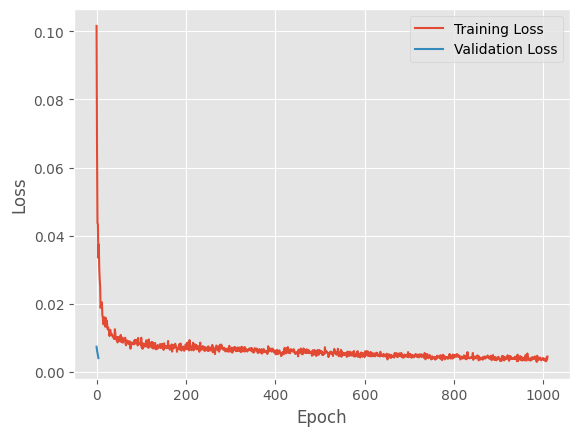

In [ ]:
# Plot the training and validation losses
# plt.figure(figsize=(10, 7))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


### 3.3 Evaluate the model

In [ ]:
# # Evaluate model
# model.eval()

# # Prepare test data
# X_test_tensor = torch.tensor(X_test.reshape(4836, 12, 500), dtype=torch.float32)  # Add channel dimension
# y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# # Predict
# with torch.no_grad():
#     y_pred = model(X_test_tensor)

# # Calculate loss
# test_loss = criterion(y_pred, y_test_tensor)
# print(f'Test Loss: {test_loss.item()}')

In [ ]:
# Save the model
# torch.save(model.state_dict(), '1dcnn.pth')